In [66]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

from thinkbayes2 import Pmf, Cdf, Suite, Joint, EvalBinomialPmf, Hist
import thinkplot
import numpy as np
import random
from scipy.signal import convolve2d

# Battleship Problem
First, I will make a simple class that will update its hypotheses about the ship's location based on whether its shot was a hit or a miss. This is pretty straightforward. For now, we will use the exponential verson of the likelihood function, if I have time, I might circle back and improve that.

In [83]:
class battleship_hunter(Suite, Joint):
    def __init__(self):
        xs = np.linspace(0, 10, 11)
        pairs = []
        for x in xs:
            for y in xs:
                pairs.append((x, y))
        self.pairs = pairs
        Suite.__init__(self, pairs)
    def Likelihood(self, data, hypo):
        """
        data: a tuple containing a tuple and a Boolean, ((where we shot), hit or miss)
        hypo: Location of the ship
        """
        coord_fired, hit = data
        coord_h = hypo
        
        dist = np.linalg.norm(np.array(coord_h) - np.array(coord_fired))
        like_hit =  np.exp(-dist)
        if hit:
            return like_hit 
        else:
            return 1-like_hit

/home/jonah/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


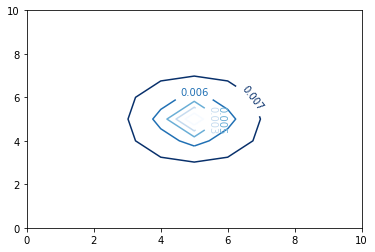

In [84]:
ship = battleship_hunter()
coord = (5, 5)
data = (coord, False)
ship.Update(data)
thinkplot.Contour(ship)

(0.0, 10.0)


/home/jonah/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


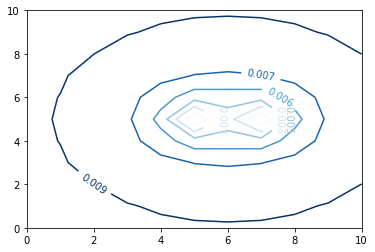

In [7]:
coord = (7, 5)
data = (coord, False)
ship.Update(data)
thinkplot.Contour(ship)

print(ship.MAP())

(1.0, 3.0)


/home/jonah/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


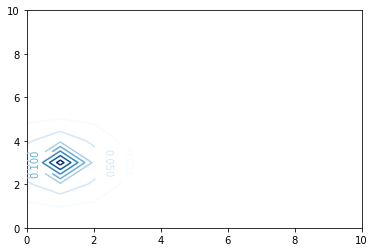

In [4]:
coord = (1, 3)
data = (coord, True)
ship.Update(data)
thinkplot.Contour(ship)

print(ship.MAP())

### The Game
First, I am going to make a class which will act how the problem describes, reporting a hit probabilistically as a function of distance. I will include methods to initialize a random coordinate, to check to see if it should report a hit, and to let us know how we did at the end.

In [6]:
class Battleship():
    def __init__(self, coord=None):
        #Pick a random coordinate unless you provide one
        if coord == None:
            self.coord = (random.randint(0,10), random.randint(0,10))
        else:
            self.coord = coord
    def check_for_hit(self, attack):
        #Decides whether or not it will report a hit
        dist = np.linalg.norm(np.array(self.coord) - np.array(attack))
        p = np.exp(-dist)
        if random.random() < p:
            #If p (or probability of reporting hit) is really big, will usually return a hit
            return True
        else:
            return False
    def spill_secrets(self, verbose=False):
        #To find out at the end how well we did.
        if verbose == True:
            print(self.coord)
        return self.coord

Next comes the hard part. I need some sort of search algorithm. The simplest possible one would just find the MAP of the joint distribution and shoot there. Let's see how many tries it takes that algorithm to get some certainty (say, 90%, for now) that it knows where the ship is.

First, I need to add a method to my battleship hunter class to find its next target. (For now, I could just use the .MAP() method, but soon I will be changing it, so I want to include it so I can reuse functions later)

In [7]:
class MAP_battleship_hunter(battleship_hunter):
    def next_target(self):
        return self.MAP()

Now, a function that wraps up all these methods and continues firing until the hunter thinks it has found the ship.

In [21]:
def play_battleship(ship_type, f_shot, coord=None, cert_thresh = 0.9, verbose=False):
    
    # Initialize both the ship and the hunter
    
    hunter = ship_type()
    
    # Begin loop. Until certain enough, keep shooting.
    certainty = 0
    shots = 0
    if fshot:
        first_shot = True
    
    while certainty < cert_thresh:
        if first_shot:
            coord = hunter.next_target(first_shot)
            first_shot = False
        else:
            coord = hunter.next_target()
        hit = hidden_ship.check_for_hit(coord)
        hunter.Update((coord, hit))
        certainty = hunter[hunter.MAP()] # I am sure there is a method for this but I don't know what it is.
        shots += 1
    
    spot = hidden_ship.spill_secrets(verbose)
    if verbose==True:
        print("Best Guess:\n", hunter.MAP())
        print("Actual result:")
        print("Shots require: " + str(shots))
    return shots, hunter.MAP(), spot

Great, now we can run that simulation to get an idea of an average. Because this model is deterministic (right now) for each location, I only have to run it once for each pair.

In [11]:
def test_class(ship_type):
    shots = []
    xs = np.linspace(0, 10, 11)
    pairs = []
    for x in xs:
        for y in xs:
            pairs.append((x, y))
    shot_map = {}
    for pair in pairs:
        shot = play_battleship(MAP_battleship_hunter, coord=pair)[0]
        shots.append(shots)
        shot_map[pair] = shot
    print("Lowest:", np.amin(shots))
    print("Highest:", np.amax(shots))
    print("Average:", np.mean(shots))
    print("Standard Deviation:", np.std(shots))
    thinkplot.Hist(Hist(shots))

In [106]:
class convolver(battleship_hunter):
    def next_target(self, first_shot):
        if first_shot:
            return (5,5)
        kernel = np.ones((3,3)) #For now, we might test the shape and values of the kernal in a bit.
        #First, build grid of probs (can probably do with a method but whatever)
        probs = [[None]*11]*11
        for x, px in self.Marginal(0).Items():
            for y, py in self.Marginal(1).Items():
                probs[int(y)][int(x)] = px*py
        heatmap = convolve2d(probs, kernel, mode='same')
        heatmap = np.array(heatmap)
        print(heatmap)
        
        return (3,3)
        
        

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[[0.03305785 0.04958678 0.04958678 0.04958678 0.04958678 0.04958678
  0.04958678 0.04958678 0.09316304 0.09316304 0.07663411]
 [0.04958678 0.07438017 0.07438017 0.07438017 0.07438017 0.07438017
  0.07438017 0.07438017 0.13974455 0.13974455 0.11495116]
 [0.04958678 0.07438017 0.07438017 0.07438017 0.07438017 0.07438017
  0.07438017 0.07438017 0.13974455 0.13974455 0.11495116]
 [0.04958678 0.07438017 0.07438017 0.07438017 0.07438017 0.07438017
  0.07438017 0.07438017 0.13974455 0.13974455 0.11495116]
 [0.04958678 0.07438017 0.07438017 0.07438017 0.07438017 0.07438017
  0.07438017 0.07438017 0.13974455 0.13974455 0.11495116]
 [0.04958678 0.07438017 0.07438017 0.07438017 0.07438017 0.07438017
  0.07438017 0.07438017 0.13974455 0.13974455 0.11495116]
 [0.04958678 0.07438017 0.07438017 0.07438017 0.07438017 0.07438017
  0.07438017 0.07438017 0.13974455 0.13974455 0.11495116]
 [0.04958678 0.07438017 0.07438017 0.07438017 0.07438017 0.07438017
  0.07438017 

/home/jonah/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


(3, 3)

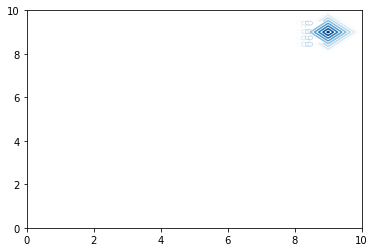

In [110]:
ship = convolver()
coord = (9,9)
ship[coord] *= 30
ship.Normalize
# data = (coord, False)
# ship.Update(data=data)
thinkplot.Contour(ship)
ship.next_target(False)